<a href="https://colab.research.google.com/github/fdeloscogna/Python_experiment/blob/main/Tesi_Python_section.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification running resnet50 pre-trained model

Add some element and esperimentation with image padding to see what it changes

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *
from torchvision import transforms
from torchvision.models import *
from sklearn.utils import class_weight
from torch.utils.data import DataLoader,Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.models import Model
from torchvision import models,transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

import random
#Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the seeds
set_seeds()

Mounted at /content/drive


In [ ]:
# Setting the device
if torch.cuda.is_available():
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    print('"Runtime" --> "Change runtime type" --> "Hardware accelerator" --> "GPU" --> "Save"')
    device = torch.device("cpu")

GPU enabled!


In [ ]:
#Import the dataset available
image_directory = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification'
labels_file_path = '/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification/labels.csv'
#read the labeled data
labeled_data = pd.read_csv(labels_file_path)
# Read the CSV file containing the labels into a Pandas DataFrame and store it in labeled_data.
# Get the labeled image filenames and their corresponding labels
labeled_filenames = labeled_data['id'].astype(str).values
labels = labeled_data['malignant'].values + 1

In [ ]:
#Let's define a proper list of the labeled images
#3 classes are available, 1, 0, -1
tr = pd.read_csv(os.path.join(image_directory,'labels.csv'))
tr['Image_id'] = ''
for i in range(len(tr)):
  tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'
tr.head()

<ipython-input-4-37b977ffbd52>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr['Image_id'][i] = 'img_' + str(tr.loc[i, ('id')]) + '.png'


,id,malignant,Image_id
0,441,-1,img_441.png
1,33284,-1,img_33284.png
2,38771,1,img_38771.png
3,46784,-1,img_46784.png
4,57613,-1,img_57613.png


Deal with data transformation

In [ ]:
#Non labeled
os.chdir("/content/drive/MyDrive/Tesi/Esempio OXML/oxml-carinoma-classification")
!ls

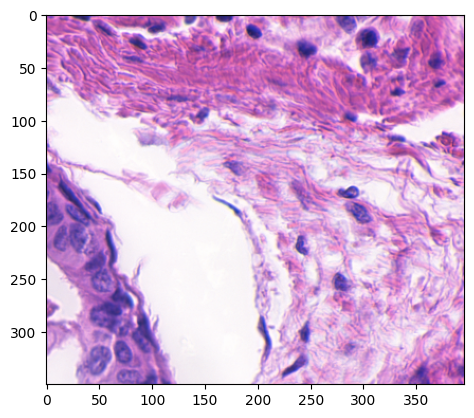

In [ ]:
#Show here the image of the tissue
img = Image.open('img_441.png')
plt.imshow(img)

In [ ]:
#Let's impose a custom dataset CustomDataset class is designed to be flexible,
#To provide filenames and labels explicitly or read them from a CSV file because It supports image transformations for data augmentation
class CustomDataset(Dataset):
    def __init__(self, image_directory, labels_file_path, transform=None, provided_filenames=None, provided_labels=None):
        """
        CustomDataset builder section.
        Parameters considered in the function:
        - transform (callable, optional): here it is a optional transform to be applied to the images.
        - provided_filenames (list, optional): List of filenames corresponding to the images.
        - provided_labels (list, optional): List of labels corresponding to the images.
        """
        self.image_directory = image_directory
        self.labels_df = pd.read_csv(labels_file_path)
        self.transform = transform

        # Use provided filenames and labels if available
        if provided_filenames is not None and provided_labels is not None:
            self.filenames = provided_filenames
            self.labels = provided_labels
            self.use_additional_data = True
        else:
            self.filenames = self.labels_df['id'].astype(str).values
            self.labels = self.labels_df['malignant'].values + 1
            self.use_additional_data = False

    def __len__(self):
        """
        The folowing part it gives the number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.
        Parameters:
        - idx (int): Index of the item to retrieve.
        """
        if self.use_additional_data:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.filenames[idx]) + '.png')
        else:
            img_path = os.path.join(self.image_directory, 'img_' + str(self.labels_df.iloc[idx]['id']) + '.png')

        image = Image.open(img_path).convert('RGB')
        #Since, from literature, many machine learning models and image processing libraries expect images to be in RGB format for consistency.
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        #It return here a tuble with the image and its label
        return image, label

In [ ]:
max_width = 0
max_height = 0
# Initialize variables to store the maximum width and height of the images.

for file_name in labeled_filenames:
    file_path = os.path.join(image_directory, "img_" + file_name + '.png')
    image = Image.open(file_path)
    width, height = image.size
    max_width = max(max_width, width)
    max_height = max(max_height, height)
    '''
    Iterate over the labeled_filenames and open each image using PIL.
    Get the width and height of each image and update the maximum width and height if necessary.
    '''

In [ ]:
# Define the main data transform
main_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

'''
Create a transformation pipeline using transforms compose.
The pipeline resizes the images to the maximum width and height found earlier,
converts them to tensors, and applies normalization.
'''

# Create the main dataset
dataset = CustomDataset(image_directory, labels_file_path, transform=main_transform)

'''
Create an instance of the CustomDataset class using the image_dir, labels_file,
and the main_transform defined above.
'''

# Define data augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

'''
Create another transformation pipeline for data augmentation.
The pipeline includes resizing, random horizontal and vertical flips,
random rotation, color jitter, tensor conversion, and normalization.
'''

dataset_augmented = CustomDataset(image_directory, labels_file_path, transform=augmentation_transform)
'''
Create another instance of the CustomDataset class using the image_dir, labels_file,
and the augmentation_transform defined above.
'''

# Define data augmentation transforms 2
augmentation_transform_2 = transforms.Compose([
    transforms.Resize((max_height, max_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((max_height, max_width), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''
Create a third transformation pipeline for more data augmentation.
The pipeline includes resizing, random horizontal and vertical flips,
random rotation, color jitter, random affine transformation, random resized crop,
random perspective, tensor conversion, and normalization.
'''

dataset_augmented_2 = CustomDataset(image_directory, labels_file_path, transform=augmentation_transform_2)
'''
Create another instance of the CustomDataset class using the image_dir, labels_file,
and the augmentation_transform_2 defined above.
'''

stacked_dataset = ConcatDataset([dataset, dataset_augmented])
'''
Combine the main dataset and the augmented dataset using ConcatDataset.
This creates a single dataset that contains both original and augmented data.
'''

stacked_labels = np.concatenate([labels, labels])
'''
Concatenate the labels array with itself to match the combined dataset size.
This ensures that the labels are aligned with the corresponding images in stacked_dataset.
'''

# Define the number of folds for k-fold cross-validation
k_folds = 8
# Specify the number of folds to use for k-fold cross-validation.


# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
'''
Create an instance of StratifiedKFold, which performs stratified k-fold cross-validation.
It splits the data into k folds while preserving the class distribution.
The shuffle parameter is set to True to shuffle the data before splitting,
and the random_state is set to 42 for reproducibility.
'''

fold_scores = []
# Create an empty list to store the scores for each fold.


for fold, (train_index, val_index) in enumerate(skf.split(stacked_dataset, stacked_labels)):
    # Iterate over each fold generated by the StratifiedKFold object.

    print(f"Training on fold {fold + 1}/{k_folds}")

    # Split the dataset into train and validation sets for the current fold
    train_data = [stacked_dataset[idx] for idx in train_index]
    val_data = [stacked_dataset[idx] for idx in val_index]
    '''
    Obtain the indices for the training and validation data for the current fold
    and extract the corresponding data from the stacked_dataset.
    '''

    # Convert labels to numpy array for indexing
    stacked_labels = np.array(stacked_labels)
    # Convert the stacked_labels to a numpy array for easier indexing.


    # Calculate class weights
    class_weights = 1.0 / torch.tensor(np.bincount(stacked_labels[train_index]))
    '''
    Compute the class weights by taking the reciprocal of the counts of each class in the training set.
    This gives more weight to underrepresented classes and less weight to overrepresented classes.
    '''
    train_class_weights = class_weights[stacked_labels[train_index]]
    # Extract the class weights corresponding to the training labels.


    # Create the weighted sampler
    sampler = WeightedRandomSampler(train_class_weights, len(train_data), replacement=True)
    '''
    Create a WeightedRandomSampler, which samples elements from the training data with replacement
    according to the specified class weights. This oversamples the underrepresented classes
    during training to balance the class distribution.
    '''

    # Create the data loaders with weighted sampling
    batch_size = 8
    train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    # Create a DataLoader for the training data, using the WeightedRandomSampler to sample batches.
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    # Create a DataLoader for the validation data without sampling, shuffling the data within each epoch is not needed in validation.

Training on fold 1/8
Training on fold 2/8
Training on fold 3/8
Training on fold 4/8
Training on fold 5/8
Training on fold 6/8
Training on fold 7/8
Training on fold 8/8


In [ ]:
##################################################
# Visualize Image Augmentation
##################################################
'''
for k, v in tr.items():
  print(k)
  plt.figure(figsize=(25, 20))
  for idx in range(20):
      plt.subplot(1, 20, idx + 1)
      #img = np.array(v[idx].reshape(28,28))
      #plt.title(f'{y_labels[new_y_test[idx]]}')
      img_path = os.path.join(image_directory, 'img_' + str(labels_df.iloc[idx]['id']) + '.png')
      plt.imshow(img_path, cmap='gray')
      plt.axis('off')
  plt.show()
  '''

Resnet Pre trained model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - ResNet50 Training Loss: 1.2202
Epoch 2/10 - ResNet50 Training Loss: 1.0013
Epoch 3/10 - ResNet50 Training Loss: 1.0000
Epoch 4/10 - ResNet50 Training Loss: 0.9294
Epoch 5/10 - ResNet50 Training Loss: 0.8899
Epoch 6/10 - ResNet50 Training Loss: 0.8748
Epoch 7/10 - ResNet50 Training Loss: 0.8172
Epoch 8/10 - ResNet50 Training Loss: 0.8034
Epoch 9/10 - ResNet50 Training Loss: 1.0114
Epoch 10/10 - ResNet50 Training Loss: 0.7494


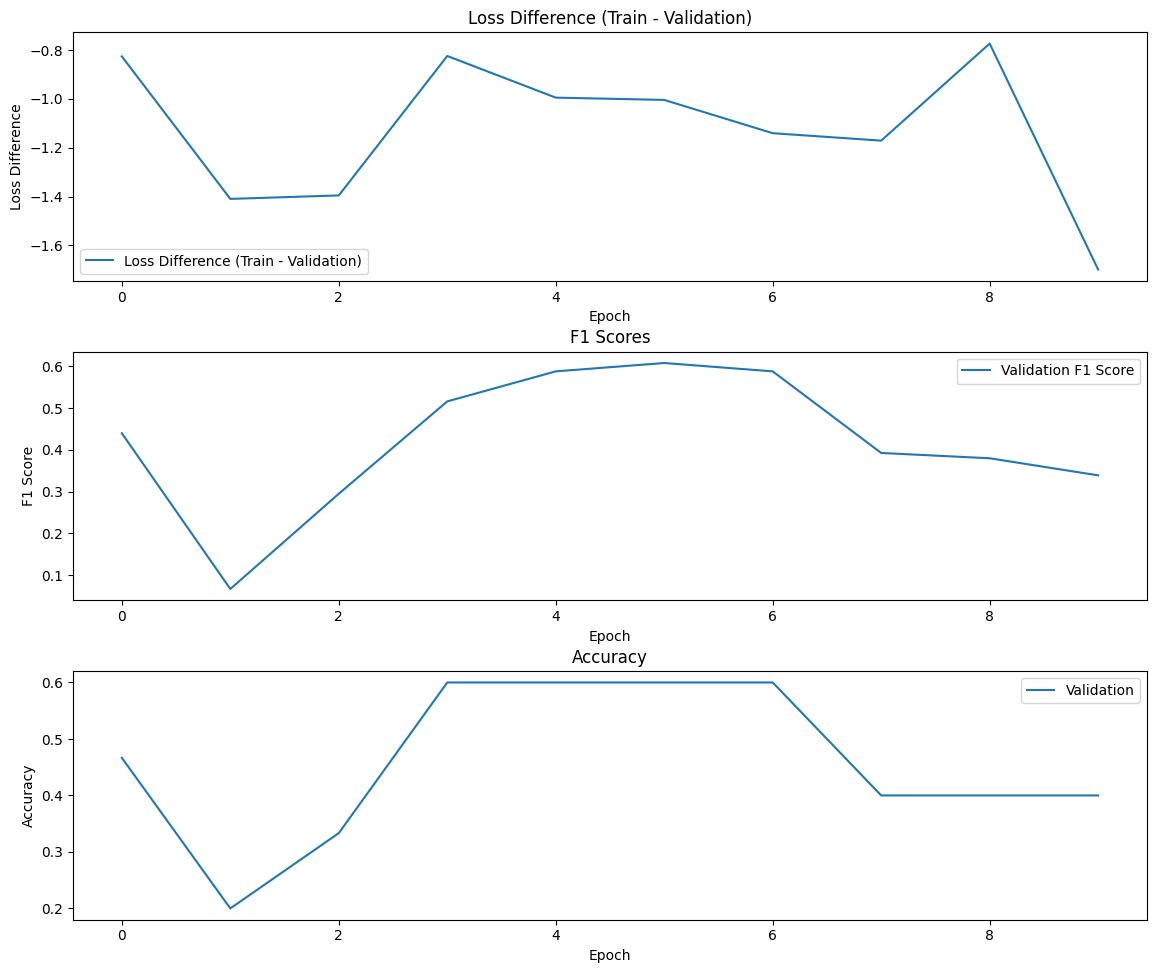

In [ ]:
import matplotlib.pyplot as plt

# Load pre-trained models
resnet_model = models.resnet50(pretrained=True)

# Freeze all the parameters of the pretrained model
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes
num_classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move the model to the device (GPU if available)
resnet_model = resnet_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer

optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
#optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=[12, 10])  # Two rows and two columns of subplots
fig.tight_layout(pad=3.0)

# Lists to store training and validation losses and F1 scores
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

# Training loop
num_epochs = 10  # Replace with the actual number of epochs
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = criterion(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    # Append the loss values to the respective lists
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)


    val_loss /= len(val_dataloader)

    val_f1 = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores.append(val_f1)      # Replace with actual validation F1 score
    val_accuracies.append(val_accuracy)      # Replace with actual validation accuracy

loss_difference = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Plot the loss difference
axs[0].plot(loss_difference, label='Loss Difference (Train - Validation)')
axs[0].set_title('Loss Difference (Train - Validation)')
axs[0].set_ylabel('Loss Difference')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot training and validation F1 scores
axs[1].plot(val_f1_scores, label='Validation F1 Score')
axs[1].set_title('F1 Scores')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].legend()

#Accuracy
axs[2].plot(val_accuracies, label='Validation')
axs[2].set_title('Accuracy')
axs[2].set_ylabel('Validation accuracy')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Show or save the plot as needed
plt.show()


In [ ]:
# Load pre-trained models
resnet_model = models.resnet50(pretrained=True)

# Freeze all the parameters of the pretrained model
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes
num_classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Move the model to the device (GPU if available)
resnet_model = resnet_model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer

optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
#optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    # Training phase for ResNet50
    resnet_model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = criterion(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    val_loss /= len(val_dataloader)

    val_f1 = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy = accuracy_score(total_labels.cpu(), total_predictions.cpu())

    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1:.4f}, Accuracy: {val_accuracy:.4f}")

    # ... (Confusion matrix, saving the best model, and recall values)

print("Training complete.")


Epoch 1/5 - ResNet50 Training Loss: 0.8397
Epoch 2/5 - ResNet50 Training Loss: 0.7978
Epoch 3/5 - ResNet50 Training Loss: 0.6673
Epoch 4/5 - ResNet50 Training Loss: 0.7111
Epoch 5/5 - ResNet50 Training Loss: 0.7131


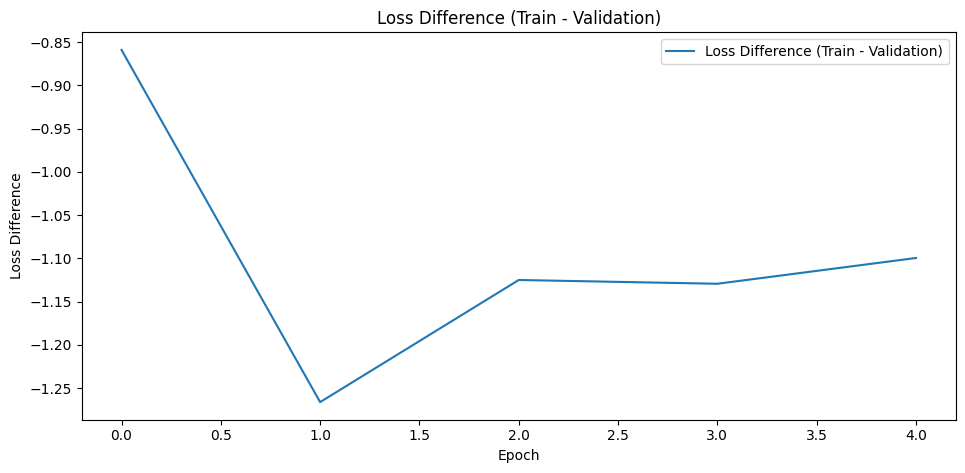

In [ ]:
#Here the proof of why is it better use 3 epoch

import matplotlib.pyplot as plt

# Initialize subplots
fig, ax = plt.subplots(figsize=[10, 5])
fig.tight_layout(pad=3.0)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Training phase for ResNet50
    resnet_model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = criterion(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    # Append the loss values to the respective lists
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

# Calculate the difference between training and validation losses
loss_difference = [train_loss - val_loss for train_loss, val_loss in zip(train_losses, val_losses)]

# Plot the loss difference
ax.plot(loss_difference, label='Loss Difference (Train - Validation)')
ax.set_title('Loss Difference (Train - Validation)')
ax.set_ylabel('Loss Difference')
ax.set_xlabel('Epoch')
ax.legend()

# Show or save the plot as needed
plt.show()

Show properly F1 score

Epoch 1/15 - ResNet50 Training Loss: 0.5902
Epoch 2/15 - ResNet50 Training Loss: 0.6659
Epoch 3/15 - ResNet50 Training Loss: 0.6009
Epoch 4/15 - ResNet50 Training Loss: 0.5626
Epoch 5/15 - ResNet50 Training Loss: 0.6875
Epoch 6/15 - ResNet50 Training Loss: 0.6274
Epoch 7/15 - ResNet50 Training Loss: 0.6386
Epoch 8/15 - ResNet50 Training Loss: 0.4631
Epoch 9/15 - ResNet50 Training Loss: 0.5988
Epoch 10/15 - ResNet50 Training Loss: 0.7189
Epoch 11/15 - ResNet50 Training Loss: 0.6678
Epoch 12/15 - ResNet50 Training Loss: 0.5873
Epoch 13/15 - ResNet50 Training Loss: 0.6789
Epoch 14/15 - ResNet50 Training Loss: 0.5118
Epoch 15/15 - ResNet50 Training Loss: 0.6810


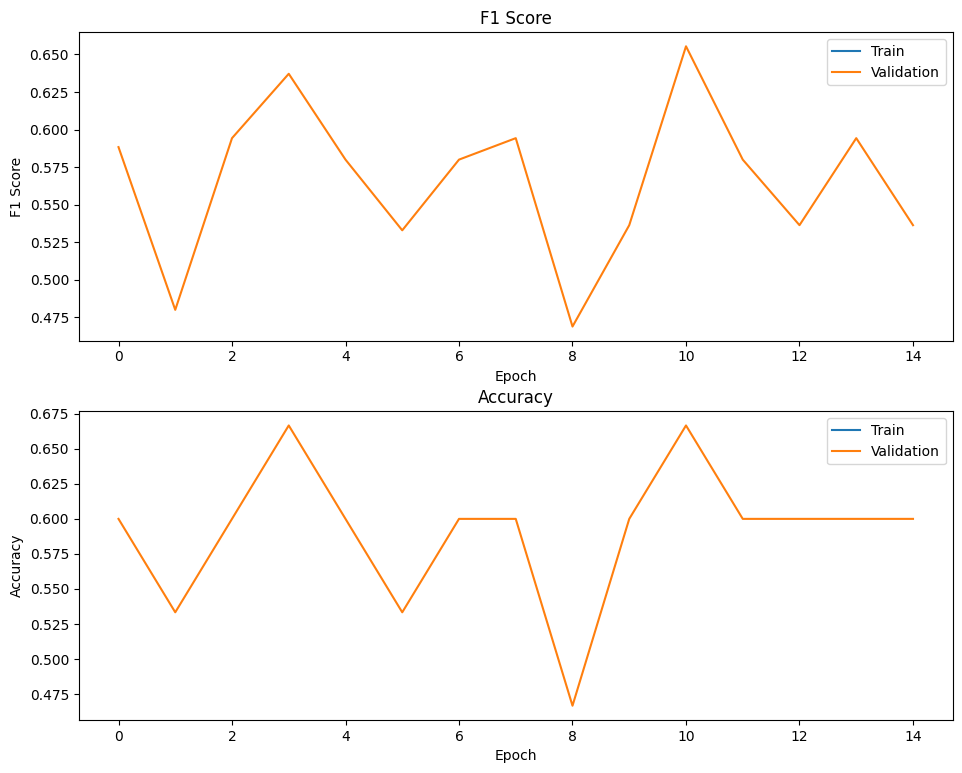

In [ ]:
import matplotlib.pyplot as plt

# Initialize subplots
fig, axs = plt.subplots(2, 1, figsize=[10, 8])  # Two subplots for F1 score and accuracy
fig.tight_layout(pad=3.0)

# Lists to store training and validation F1 scores and accuracies
train_f1_scores = []
val_f1_scores = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 15 # Replace with the actual number of epochs
for epoch in range(num_epochs):
     # Training phase for ResNet50
    resnet_model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    # Initialize the tensor to store the total predictions.
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = criterion(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    val_loss /= len(val_dataloader)

    val_f1 = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    val_accuracy = accuracy_score(total_labels.cpu(), total_predictions.cpu())
    # Append F1 scores and accuracies to the respective lists
    val_f1_scores.append(val_f1)      # Replace with actual validation F1 score
    val_accuracies.append(val_accuracy)      # Replace with actual validation accuracy

# Plot learning curves for F1 score
axs[0].plot(train_f1_scores, label='Train')
axs[0].plot(val_f1_scores, label='Validation')
axs[0].set_title('F1 Score')
axs[0].set_ylabel('F1 Score')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot learning curves for accuracy
axs[1].plot(train_accuracies, label='Train')
axs[1].plot(val_accuracies, label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Show or save the plot as needed
plt.show()


Parte con VGG16

In [1]:
weight = models.VGG16_Weights.DEFAULT
pre_model = models.vgg16(weights = weight)

NameError: ignored

Image padding

In [ ]:
from PIL import Image, ImageOps

class PaddedImageDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None, filenames=None, labels=None, padding=None):
        """
        PaddedImageDataset class constructor.

        Parameters:
        - image_dir (str): Directory path where the images are located.
        - labels_file (str): File path of the CSV file containing the labels.
        - transform (callable, optional): Optional transform to be applied to the images.
        - filenames (list, optional): List of filenames corresponding to the images.
        - labels (list, optional): List of labels corresponding to the images.
        - padding (int or tuple, optional): Amount of padding to add to the images.
            If it's an integer, it will add the same padding to all sides.
            If it's a tuple (left, top, right, bottom), you can specify different padding values for each side.
        """
        self.image_directory = image_directory
        self.labels_df = pd.read_csv(labeled_filenames)
        self.transform = transform
        self.padding = padding

        # Use provided filenames and labels if available
        if filenames is not None and labels is not None:
            self.filenames = filenames
            self.labels = labels
            self.use_additional_data = True
        else:
            self.filenames = self.labels_df['id'].astype(str).values
            self.labels = self.labels_df['malignant'].values + 1
            self.use_additional_data = False

    def __getitem__(self, idx):
        if self.use_additional_data:
            img_path = os.path.join(self.image_dir, 'img_' + str(self.filenames[idx]) + '.png')
        else:
            img_path = os.path.join(self.image_dir, 'img_' + str(self.labels_df.iloc[idx]['id']) + '.png')

        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.padding is not None:
            # Apply padding to the image
            if isinstance(self.padding, int):
                image = ImageOps.expand(image, border=self.padding, fill='white')
            elif isinstance(self.padding, tuple) and len(self.padding) == 4:
                image = ImageOps.expand(image, border=self.padding, fill='white')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Define the padding amount (e.g., 10 pixels of padding on all sides)
padding_amount = 10

# Create an instance of the PaddedImageDataset
padded_dataset = PaddedImageDataset(
    image_dir=image_directory,
    labels_file=labeled_data,
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]),
    padding=padding_amount)

# Split the dataset into training and validation subsets
train_size = int(0.8 * len(padded_dataset))
val_size = len(padded_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(padded_dataset, [train_size, val_size])

# Create data loaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

AttributeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image, ImageOps
import pandas as pd

# Define your ResNet model
resnet_model = models.resnet50(pretrained=True)

# Freeze all the parameters of the pretrained model
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to match the number of classes
num_classes = 3
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

# Define the padding amount (e.g., 10 pixels of padding on all sides)
padding_amount = 10

# Create an instance of the PaddedImageDataset
padded_dataset = PaddedImageDataset(
    image_dir=image_directory,
    labels_file=labels_file_path,
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]),
    padding=padding_amount
)

# Split the dataset into training and validation subsets
train_size = int(0.8 * len(padded_dataset))
val_size = len(padded_dataset) - train_size
train_dataset, val_dataset = random_split(padded_dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 32  # Set your batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    # Training phase
    resnet_model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_resnet.zero_grad()

        outputs = resnet_model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch {epoch + 1}/{num_epochs} - ResNet50 Training Loss: {epoch_loss:.4f}")

    # Validation phase
    resnet_model.eval()
    val_loss = 0.0
    val_f1 = 0.0
    val_accuracy = 0.0
    total_predictions = torch.tensor([], dtype=torch.long, device=device)
    total_labels = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            resnet_outputs = resnet_model(images)
            resnet_loss = criterion(resnet_outputs, labels)

            val_loss += resnet_loss.item()

            _, predictions = torch.max(resnet_outputs, dim=1)

            total_predictions = torch.cat((total_predictions, predictions), dim=0)
            total_labels = torch.cat((total_labels, labels), dim=0)

    val_loss /= len(val_dataloader)

    # Calculate F1 score for validation
    val_f1 = f1_score(total_labels.cpu(), total_predictions.cpu(), average='weighted')

    # Calculate accuracy for validation
    val_accuracy = accuracy_score(total_labels.cpu(), total_predictions.cpu())

    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {val_loss:.4f}, F1 Score: {val_f1:.4f}, Accuracy: {val_accuracy:.4f}")

# Training complete


TypeError: ignored